In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn import neighbors, ensemble, svm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('Data/Pipeline_data_toy_bin.csv', index_col=[0])
#df = pd.read_csv('Data/Pipeline_data_bin.csv', index_col=[0])

df.head()

,bmi,cigs_before_preg,birth_time,m_deliveryweight,f_age,m_age,m_height_in,num_prenatal_visits,prior_births_dead,prior_births_living,...,m_morbidity,riskf,payment,mn_prenatalcare_began,delivery_method,res_status,prev_cesarean,infant_sex,weight_change,birthweight_bin
0,46.3,0.0,1341.0,310.0,27.499772,25.0,64.0,18.0,0.0,0.0,...,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,40.0,1
1,25.5,0.0,621.0,179.0,19.738769,16.0,65.0,6.0,0.0,0.0,...,0.0,0.0,1.0,6.0,1.0,2.0,0.0,0.0,26.0,0
2,21.8,0.0,741.0,154.0,27.000000,24.0,63.0,15.0,0.0,0.0,...,0.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,31.0,1
3,22.7,0.0,750.0,150.0,31.000000,28.0,62.0,16.0,0.0,1.0,...,0.0,1.0,1.0,3.0,2.0,1.0,1.0,0.0,26.0,0
4,34.0,3.0,1423.0,192.0,28.000000,31.0,63.0,8.0,0.0,1.0,...,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0


In [3]:
X = df.drop(['birthweight_bin'], axis=1)
y = df['birthweight_bin']

* Variance Threshold used to remove features with low variance 

In [4]:
selector = VarianceThreshold(threshold = 0.1)
X_new = selector.fit_transform(X)

In [5]:
X_new.shape

(10000, 33)

In [372]:
X.columns

Index(['bmi', 'cigs_before_preg', 'birth_time', 'm_deliveryweight', 'f_age',
       'm_age', 'm_height_in', 'num_prenatal_visits', 'prior_births_dead',
       'prior_births_living', 'prior_terminations', 'prepreg_weight',
       'num_prev_cesareans', 'time_since_menses', 'birth_attendant',
       'birth_place', 'birth_mn', 'birth_dy', 'f_education', 'f_hispanic',
       'f_race6', 'gonorrhea', 'labour_induced', 'm_nativity', 'm_education',
       'm_hispanic', 'admit_icu', 'm_race6', 'm_transferred', 'infections',
       'm_morbidity', 'riskf', 'payment', 'mn_prenatalcare_began',
       'delivery_method', 'res_status', 'prev_cesarean', 'infant_sex',
       'weight_change'],
      dtype='object')

In [518]:
features = X.columns
features[selector.get_support()]

Index(['bmi', 'cigs_before_preg', 'birth_time', 'm_deliveryweight', 'f_age',
       'm_age', 'm_height_in', 'num_prenatal_visits', 'prior_births_living',
       'prior_terminations', 'prepreg_weight', 'num_prev_cesareans',
       'time_since_menses', 'birth_attendant', 'birth_place', 'birth_mn',
       'birth_dy', 'f_education', 'f_hispanic', 'f_race6', 'labour_induced',
       'm_nativity', 'm_education', 'm_hispanic', 'm_race6', 'riskf',
       'payment', 'mn_prenatalcare_began', 'delivery_method', 'res_status',
       'prev_cesarean', 'infant_sex', 'weight_change'],
      dtype='object')

* Feature selection

In [6]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
X_new = fs.fit_transform(X, y)

In [7]:
X.columns

Index(['bmi', 'cigs_before_preg', 'birth_time', 'm_deliveryweight', 'f_age',
       'm_age', 'm_height_in', 'num_prenatal_visits', 'prior_births_dead',
       'prior_births_living', 'prior_terminations', 'prepreg_weight',
       'num_prev_cesareans', 'time_since_menses', 'birth_attendant',
       'birth_place', 'birth_mn', 'birth_dy', 'f_education', 'f_hispanic',
       'f_race6', 'gonorrhea', 'labour_induced', 'm_nativity', 'm_education',
       'm_hispanic', 'admit_icu', 'm_race6', 'm_transferred', 'infections',
       'm_morbidity', 'riskf', 'payment', 'mn_prenatalcare_began',
       'delivery_method', 'res_status', 'prev_cesarean', 'infant_sex',
       'weight_change'],
      dtype='object')

In [8]:
features = X.columns
features[fs.get_support()]

Index(['bmi', 'cigs_before_preg', 'm_deliveryweight', 'f_age', 'm_age',
       'm_height_in', 'num_prenatal_visits', 'prior_births_dead',
       'prior_births_living', 'prepreg_weight', 'num_prev_cesareans',
       'time_since_menses', 'birth_attendant', 'birth_place', 'f_education',
       'f_race6', 'gonorrhea', 'labour_induced', 'm_nativity', 'm_hispanic',
       'admit_icu', 'm_race6', 'm_transferred', 'infections', 'riskf',
       'payment', 'mn_prenatalcare_began', 'delivery_method', 'res_status',
       'weight_change'],
      dtype='object')

In [9]:
X = X[['cigs_before_preg', 'm_height_in', 'num_prenatal_visits',
       'prior_births_dead', 'prior_terminations', 'prepreg_weight',
       'time_since_menses', 'birth_attendant', 'birth_place', 'birth_dy',
       'f_education', 'f_race6', 'gonorrhea', 'labour_induced', 'm_nativity',
       'm_education', 'm_hispanic', 'admit_icu', 'm_race6', 'm_transferred',
       'infections', 'm_morbidity', 'riskf', 'payment',
       'mn_prenatalcare_began', 'delivery_method', 'res_status',
       'prev_cesarean', 'infant_sex', 'weight_change']]

### Pre-processing

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [21]:
num_cols = ('cigs_before_preg','m_height_in','num_prenatal_visits','prior_births_dead','prior_terminations',
            'prepreg_weight','time_since_menses','weight_change','mn_prenatalcare_began')

bin_cols = ('gonorrhea','labour_induced','admit_icu','m_transferred','infections','m_morbidity','riskf',
            'prev_cesarean','infant_sex')

cat_cols = ('birth_attendant','birth_place','birth_dy','f_education','f_race6','m_nativity','m_education',
            'm_hispanic','m_race6','payment','delivery_method','res_status')

In [525]:
#num_cols = ('bmi','cigs_before_preg','birth_time','m_deliveryweight','f_age','m_age','m_height_in',
#            'num_prenatal_visits','prior_births_dead','prior_births_living','prior_terminations','prepreg_weight',
#            'num_prev_cesareans','time_since_menses','weight_change','mn_prenatalcare_began')

#bin_cols = ('gonorrhea','labour_induced','admit_icu','m_transferred','infections','m_morbidity','riskf',
#            'prev_cesarean','infant_sex')

#cat_cols = ('birth_attendant','birth_place','birth_mn','birth_dy','f_education','f_hispanic','f_race6',
#                'm_nativity','m_education','m_hispanic','m_race6','payment','delivery_method','res_status')

In [22]:
num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())])


preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('num', num_transformer , num_cols),
            ('cat', cat_transformer , cat_cols)
        ])

In [23]:
X_processed = preprocessor.fit_transform(X)

In [24]:
X_processed = pd.DataFrame(X_processed)

In [25]:
X_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,-0.230973,-0.049740,1.641846,-0.083903,0.643220,2.627516,-1.061473,0.669958,-0.593919,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.230973,0.310014,-1.326265,-0.083903,-0.477463,-0.151832,0.032711,-0.215591,2.062843,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.230973,-0.409494,0.899818,-0.083903,-0.477463,-0.864486,0.032711,0.100676,-0.593919,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.230973,-0.769248,1.147161,-0.083903,0.643220,-0.840731,0.073236,-0.215591,0.070271,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.366727,-0.409494,-0.831580,-0.083903,0.643220,0.774617,0.113762,-1.860183,-0.593919,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


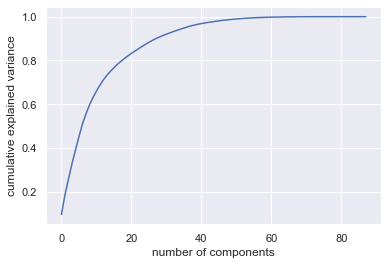

In [26]:
pca = PCA().fit(X_processed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [27]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_processed)

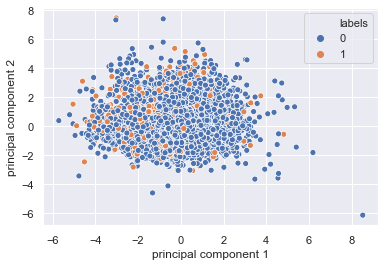

In [37]:
# Extract the projections of the first 2 components
pca2 = X_pca[:, :2]

# Plot the first 2 components
principalDf = pd.DataFrame(data = pca2, 
                           columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([y, principalDf], axis = 1)
finalDf.columns = ['labels', 'principal component 1', 'principal component 2']

ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue='labels', data=finalDf)
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

### KNN

In [64]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [65]:
y_pred = knn.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1800   23]
 [ 149   28]]


In [60]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

Number of low-bw cases in test set = 177
Number of correctly predicted low-bw cases = 28


In [61]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(1800, 23, 149, 28)

### SVM

In [66]:
from sklearn.svm import SVC

In [422]:
X_processed_svm = X[['num_prenatal_visits','cigs_before_preg']]

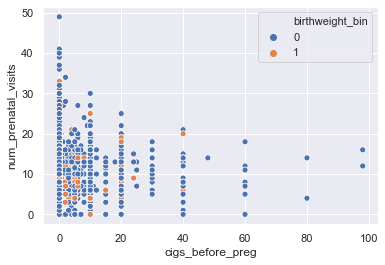

In [423]:
sns.scatterplot(X_processed_svm['cigs_before_preg'], X_processed_svm['num_prenatal_visits'], hue=y);

In [120]:
#X_train, X_test, y_train, y_test = train_test_split(X_processed_svm, y, test_size=0.2, random_state=0)

In [67]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    X, Y = np.meshgrid(x,y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    

    ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

AttributeError: module 'sklearn.svm' has no attribute 'decision_function'

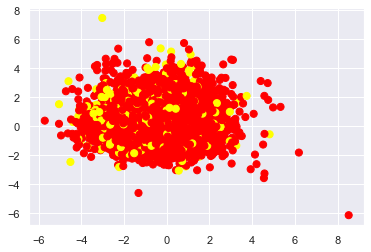

In [69]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm)
plt.show()

In [70]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator=SVC(), param_grid={'C': [8, 9, 10], 'gamma': [0.02, 0.03, 0.04]})

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [8, 9, 10], 'gamma': [0.02, 0.03, 0.04]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [71]:
clf.best_params_

{'C': 8, 'gamma': 0.03}

In [74]:
svm = SVC(gamma=0.03, kernel='rbf', C=9)
svm.fit(X_train, y_train)

SVC(C=9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [75]:
y_pred = svm.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1805   18]
 [ 127   50]]


In [76]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

Number of low-bw cases in test set = 177
Number of correctly predicted low-bw cases = 50


In [77]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(1805, 18, 127, 50)

### KMeans

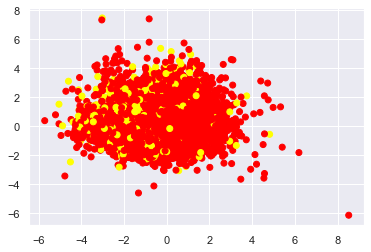

ValueError: 'c' argument has 10000 elements, which is not acceptable for use with 'x' with size 20000, 'y' with size 20000.

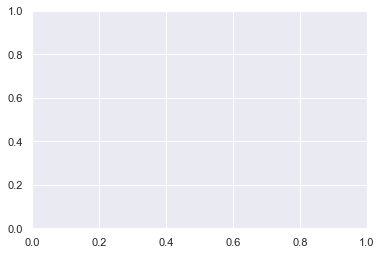

In [84]:
from sklearn.cluster import KMeans

plt.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], c=y, cmap='autumn')
plt.show()

def plot_kmeans_n(n=2, data_set=X):
    kmeans = KMeans(n_clusters=n)
    
    # Predict the centers of the datasets using fit_predict
    y_pred = kmeans.fit_predict(data_set)
    
    # Plot
    plt.scatter(data_set.iloc[:, :], data_set.iloc[:, :], c=y_pred)
    plt.title(f'N={n}')
    plt.show()

# Try running this function for different values of n
plot_kmeans_n(2, principalDf)

In [85]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

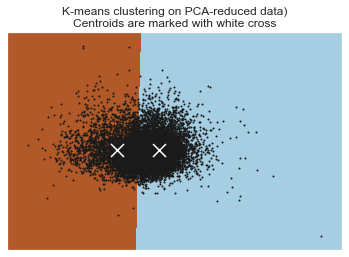

In [88]:
kmeans2 = KMeans(n_clusters=2).fit(principalDf)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = principalDf.iloc[:, 0].min() - 1, principalDf.iloc[:, 0].max() + 1
y_min, y_max = principalDf.iloc[:, 1].min() - 1, principalDf.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(principalDf.iloc[:, 0], principalDf.iloc[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans2.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

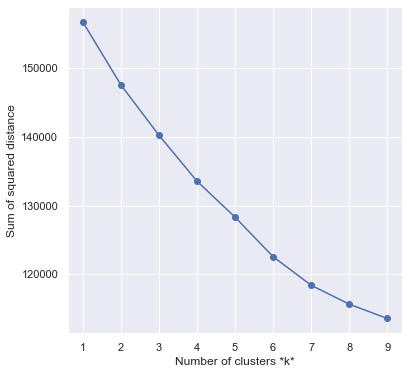

In [90]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_processed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Linear Discriminant Analysis

In [557]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=0.2, random_state=0)

In [562]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_f, y_train_f)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [563]:
y_pred = lda.predict(X_test_f)

cm = metrics.confusion_matrix(y_test_f, y_pred_f)
print(cm)

[[1813   10]
 [ 140   37]]


In [560]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

Number of low-bw cases in test set = 177
Number of correctly predicted low-bw cases = 42


In [561]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(1813, 10, 140, 37)

### Decision tree

In [341]:
# preamble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

import graphviz 

# Helper function to plot the decision tree. This uses the graphviz library.
def plot_tree(graph, feature_names=None, class_names=None):
    '''
    This method takes a DecisionTreeClassifier object, along with a list of feature names and target names
    and plots a tree. The feature names and class names can be left empty; they are just there for labelling 
    '''
    dot_data = export_graphviz(graph, out_file=None, 
                      feature_names=feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 
    
    graph = graphviz.Source(dot_data)
    
    return graph


In [342]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [564]:
X = X.drop(['time_since_menses'], axis=1)

In [566]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)

Accuracy: 0.9125


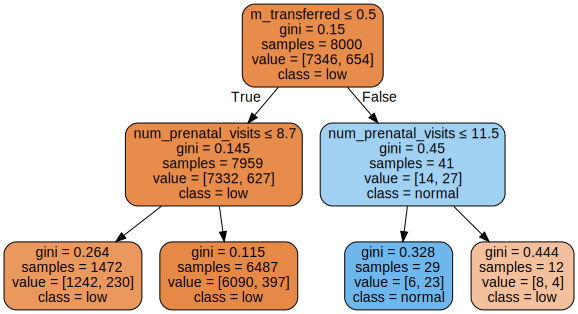

In [567]:
dt = DecisionTreeClassifier(max_depth=2).fit(X_train2, y_train2)

y_pred2 = dt.predict(X_test2)

full_model_accuracy = metrics.accuracy_score(y_test2, y_pred2)

print(f'Accuracy: {full_model_accuracy}')

plot_tree(dt, X.columns, ['low','normal'])

In [568]:
GS_model = GridSearchCV(DecisionTreeClassifier(random_state=2), 
                        {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, cv=15,)

fitted_GS_model = GS_model.fit(X_train, y_train)

Mean accurary scores:[0.9182504  0.93162604 0.9326262  0.9308758  0.93187643 0.93100088
 0.93012604 0.92962526 0.92875018 0.92662549]


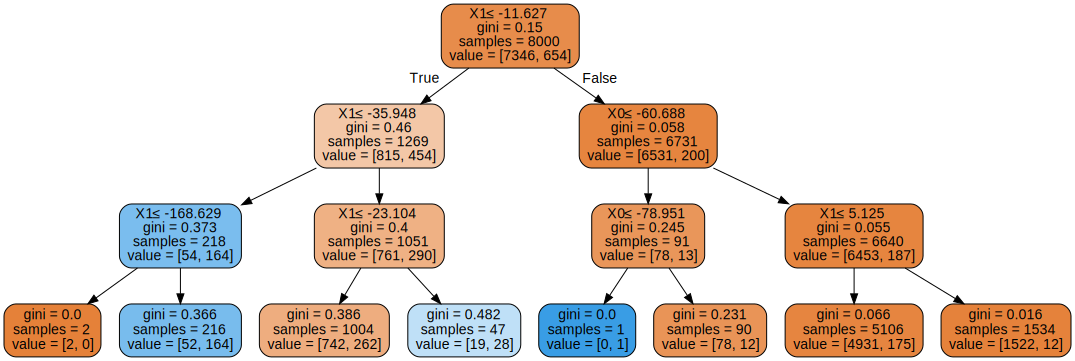

In [569]:
# 'mean_test_score' returns the average score for each parameter value over the cv fold. 
accuracy_scores = fitted_GS_model.cv_results_['mean_test_score']
print(f"Mean accurary scores:{accuracy_scores}")

# Plot the best estimator found: GridSearchCV.best_estimator_ returns the model that performed the best.
best_dt = fitted_GS_model.best_estimator_
plot_tree(best_dt)

### Random Forest

In [508]:
from sklearn.ensemble import RandomForestClassifier

In [591]:
rfc = RandomForestClassifier(max_depth=300)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [592]:
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1794   29]
 [ 120   57]]


In [593]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

Number of low-bw cases in test set = 177
Number of correctly predicted low-bw cases = 57


In [594]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(1794, 29, 120, 57)